In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/test.csv
./data/train-2.csv
./data/train.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('29/11/2020')
current_dirname = './data'

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [3]:
df_train = pd.read_csv(f'{current_dirname}/train.csv')
df_test = pd.read_csv(f'{current_dirname}/test.csv')
sample_submission = pd.read_csv(f'{current_dirname}/sample_submission.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [4]:
# объединяем трейн и тест в один датасет
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем датасеты


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описание полей датасета:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [6]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [7]:
df.client_id.nunique()

110148

Идентификатор клиента, уникальные записи, информационной нагрузки не несет. В модели не используется.

# EDA

app_date - дата подачи заявки

преобразуем в datatime формат

In [8]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [9]:
start_df_date = df.app_date.min()  # дата первой заяки в датасете
print(start_df_date)

2014-01-01 00:00:00


Посмотрим на распределение количества заявок по дням

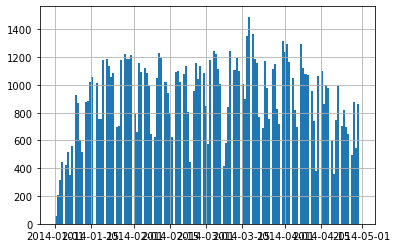

In [10]:
df.app_date.hist(bins=150)

Заявки в основном распределены равномерно, в начале января небольшой спад, видимо связан с праздничными днями.

Введем 3 новых признака: количество дней от первой даты в датасете, день недели подачи заявки и месяц подачи заявки

In [11]:
df['app_day'] = (df['app_date'] - start_df_date).dt.days
df['app_month'] = df['app_date'].dt.month
df['app_weekday'] = df['app_date'].dt.weekday
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_month,app_weekday
48243,72322,2014-03-20,UGR,F,61,N,N,0,0,-1.888096,4,70,1,1,18000,2,2,N,0.0,1,78,3,3
11026,41180,2014-02-17,PGR,M,28,Y,N,0,0,-2.712273,2,50,1,2,40000,1,1,N,0.0,1,47,2,0
50214,79519,2014-03-27,UGR,M,27,N,N,0,0,-2.466187,1,60,1,2,22000,1,3,N,0.0,1,85,3,3
55394,16653,2014-01-23,UGR,M,23,N,N,0,0,-2.316714,0,80,2,3,5000,1,3,Y,0.0,1,22,1,3
94303,23153,2014-01-30,GRD,F,28,N,N,0,0,-1.516873,2,50,1,2,25000,1,2,N,NaN,0,29,1,3


Посмотрим на строковые данные

In [12]:
# посмотрим на значения в строковых полях
for column in df.columns:
    if df[column].dtype == 'object':
        print('Уникальные значения, {0}: {1}'.format(column,df[column].unique()))

Уникальные значения, education: ['SCH' 'GRD' 'UGR' 'PGR' 'ACD' nan]
Уникальные значения, sex: ['M' 'F']
Уникальные значения, car: ['Y' 'N']
Уникальные значения, car_type: ['Y' 'N']
Уникальные значения, foreign_passport: ['N' 'Y']


В education есть пропуски, посмотрим подробнее

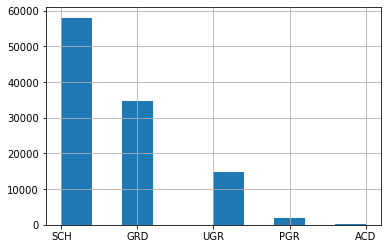

In [13]:
df.education.hist()

Заменим NaN на наиболее часто встречающееся и создадим признак обозначающий незаполненный education

In [14]:
df['education_is_nan'] = pd.isna(df['education']).astype('uint8')
df.education.fillna('SCH', inplace = True)

Разобьем данные на бинарные, категориальные и числовые

In [15]:
# бинарные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'education_is_nan']
# катеригориальные
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time', 'app_weekday', 'app_month']

# числовые
num_cols = ['age', 'income', 'bki_request_cnt']

In [16]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_month,app_weekday,education_is_nan
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,31,2,5,0
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,70,3,2,0
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,31,2,5,0
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,22,1,3,0
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,107,4,4,0


Числовые признаки

age - возраст

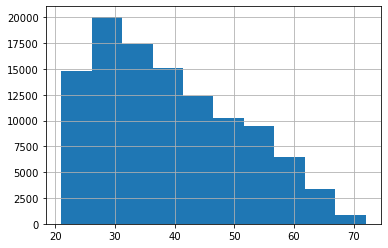

In [17]:
df.age.hist()

Распределение смещено вправо, сначала резкий рост заявок в зависимости от возраста, затем постепенное снижение. Попробуем логарифмировать для устранения смещения

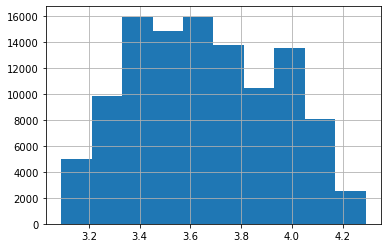

In [18]:
df.age = np.log(df.age + 1)
df.age.hist()

Распределение нормализовалось

decline_app_cnt - количество отклоненных заявок

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

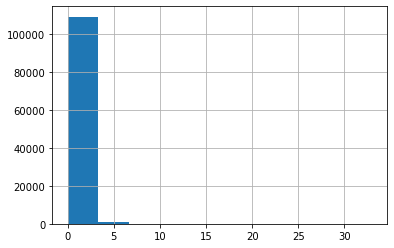

In [19]:
df.decline_app_cnt.hist()
df.decline_app_cnt.value_counts()

In [20]:
def get_stat(data):
    describe = data.describe()
    describe['iqr'] = describe['75%'] - describe['25%']
    describe['low_interval'] = describe['25%'] - 1.5 * describe['iqr']
    describe['high_interval'] = describe['75%'] + 1.5 * describe['iqr']
    return describe

get_stat(df.decline_app_cnt)

count            110148.000000
mean                  0.273205
std                   0.799099
min                   0.000000
25%                   0.000000
50%                   0.000000
75%                   0.000000
max                  33.000000
iqr                   0.000000
low_interval          0.000000
high_interval         0.000000
Name: decline_app_cnt, dtype: float64

У большинства клиентов небыло отказов в кредите, логарифмируем и посмотрим на выбросы

count            12585.000000
mean                 0.893980
std                  0.331151
min                  0.693147
25%                  0.693147
50%                  0.693147
75%                  1.098612
max                  3.526361
iqr                  0.405465
low_interval         0.084950
high_interval        1.706810
Name: decline_app_cnt_log, dtype: float64

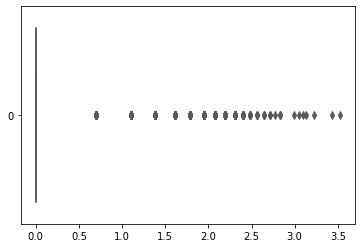

In [21]:
df['decline_app_cnt_log'] = np.log(df.decline_app_cnt + 1)
ax = sns.boxplot(data=df.decline_app_cnt_log, orient="h", palette="Set2")
decline_app_cnt_log_stat = get_stat(df[((df['decline_app_cnt_log'] > 0) & (df['train'] > 0))]['decline_app_cnt_log'])
display(decline_app_cnt_log_stat)

Значения выходящие за границу приравняем границе, последнее значение - это 4 и более запросов

In [22]:
df['decline_app_cnt_log'] = df[['decline_app_cnt_log', 'train']].apply(lambda x: decline_app_cnt_log_stat['high_interval'] if ((x['decline_app_cnt_log'] > decline_app_cnt_log_stat['high_interval'])) else x['decline_app_cnt_log'], axis=1)
decline_app_cnt_log_stat = get_stat(df[((df['decline_app_cnt_log'] > 0) & (df['train'] > 0))]['decline_app_cnt_log'])
df[(df['decline_app_cnt'] > 0)]['decline_app_cnt_log'].value_counts()


0.693147    12500
1.098612     3622
1.386294     1365
1.609438      606
1.706810      584
Name: decline_app_cnt_log, dtype: int64

In [23]:
# добавить новый признак в числовые значения
num_cols.append('decline_app_cnt_log')

score_bki - скоринговый балл по данным из БКИ

count            110148.000000
mean                 -1.904535
std                   0.499397
min                  -3.624586
25%                  -2.260434
50%                  -1.920823
75%                  -1.567888
max                   0.199773
iqr                   0.692546
low_interval         -3.299252
high_interval        -0.529070
Name: score_bki, dtype: float64

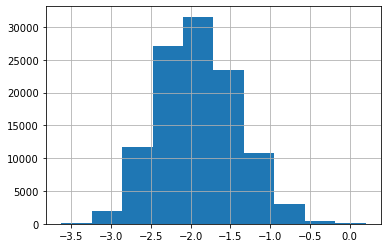

In [24]:
num_cols.append('score_bki')
df.score_bki.hist()
get_stat(df.score_bki)

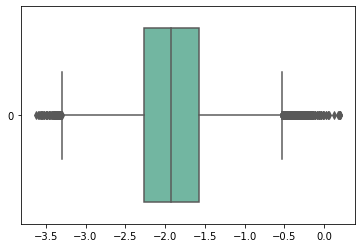

In [25]:
ax = sns.boxplot(data=df.score_bki, orient="h", palette="Set2")

In [26]:
get_stat(df.score_bki)

count            110148.000000
mean                 -1.904535
std                   0.499397
min                  -3.624586
25%                  -2.260434
50%                  -1.920823
75%                  -1.567888
max                   0.199773
iqr                   0.692546
low_interval         -3.299252
high_interval        -0.529070
Name: score_bki, dtype: float64

Распределение нормальное, пока оставим как есть

income - доход заемщика

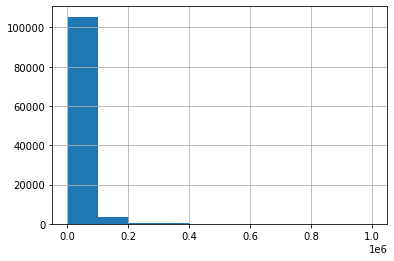

In [27]:
df.income.hist()

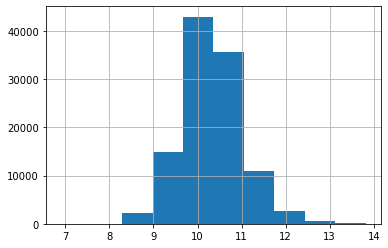

In [28]:
np.log(df.income).hist()

In [29]:
df.income = np.log(df.income)

In [30]:
# Преобразуем education в целочисленный формат
# df['education'] = label_encoder.fit_transform(df['education'])
# df.education.unique()
dic_value_edu = {'SCH':1,'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}
df['education'] = df['education'].replace(to_replace=dic_value_edu)
df.education.unique()

array([1, 2, 3, 4, 5])

In [31]:
df_cat = pd.get_dummies(df[cat_cols], columns=cat_cols, dummy_na=True)
df_cat.head()

,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_nan,home_address_1.0,home_address_2.0,home_address_3.0,home_address_nan,work_address_1.0,work_address_2.0,work_address_3.0,work_address_nan,region_rating_20.0,region_rating_30.0,region_rating_40.0,region_rating_50.0,region_rating_60.0,region_rating_70.0,region_rating_80.0,region_rating_nan,sna_1.0,sna_2.0,sna_3.0,sna_4.0,sna_nan,first_time_1.0,first_time_2.0,first_time_3.0,first_time_4.0,first_time_nan,app_weekday_0.0,app_weekday_1.0,app_weekday_2.0,app_weekday_3.0,app_weekday_4.0,app_weekday_5.0,app_weekday_6.0,app_weekday_nan,app_month_1.0,app_month_2.0,app_month_3.0,app_month_4.0,app_month_nan
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [32]:
# Стандартизация числовых переменных
df_num = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = num_cols)
df_num.head()

,age,income,bki_request_cnt,decline_app_cnt_log,score_bki
0,1.714029,-0.786072,-0.443335,-0.423451,-0.208688
1,1.542867,-0.708463,0.438921,-0.423451,0.745419
2,-1.390791,-0.052822,-0.443335,2.680628,0.993988
3,1.173250,-1.629794,-0.002207,-0.423451,-0.306243
4,0.832388,-0.052822,-0.443335,-0.423451,1.321223


In [33]:
# Объединяем
X = pd.concat([df_num, df_cat, df[bin_cols], df['train']], axis = 1)

y = df[X.train > 0]['default']
X.head(2)

,age,income,bki_request_cnt,decline_app_cnt_log,score_bki,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_nan,home_address_1.0,home_address_2.0,home_address_3.0,home_address_nan,work_address_1.0,work_address_2.0,work_address_3.0,work_address_nan,region_rating_20.0,region_rating_30.0,region_rating_40.0,region_rating_50.0,region_rating_60.0,region_rating_70.0,region_rating_80.0,region_rating_nan,sna_1.0,sna_2.0,sna_3.0,sna_4.0,sna_nan,first_time_1.0,first_time_2.0,first_time_3.0,first_time_4.0,first_time_nan,app_weekday_0.0,app_weekday_1.0,app_weekday_2.0,app_weekday_3.0,app_weekday_4.0,app_weekday_5.0,app_weekday_6.0,app_weekday_nan,app_month_1.0,app_month_2.0,app_month_3.0,app_month_4.0,app_month_nan,sex,car,car_type,foreign_passport,good_work,education_is_nan,train
0,1.714029,-0.786072,-0.443335,-0.423451,-0.208688,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1
1,1.542867,-0.708463,0.438921,-0.423451,0.745419,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


Разбиваем на тестовую и обучающую выборки

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X[X.train > 0].drop(['train'], axis=1), y, test_size = 0.3, random_state=RANDOM_SEED)

In [35]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

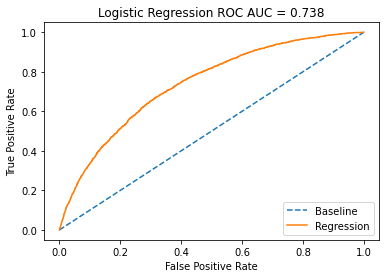

In [36]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

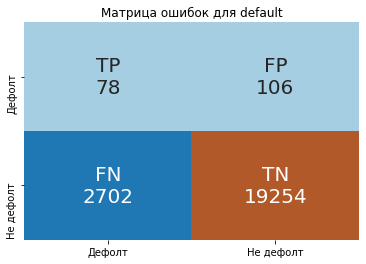

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure()
sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Paired', cbar = False, \
         xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок для default')
plt.show()

**Подбор оптимальных параметров**

In [38]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6697
Precision: 0.2275
Recall: 0.6806
F1: 0.3410


Модель на оптимальных параметрах

In [39]:
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 100
epsilon_stop = 1e-3
C = np.logspace(0, 1, 10)
param_grid = [
    {'C': C,
     'penalty': [best_parameters['penalty']],
     'solver': [best_parameters['solver']], 
     'class_weight':[best_parameters['class_weight']], 
     'multi_class': [best_parameters['multi_class']], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}

]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
##печатаем метрики
y_pred = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

	C: 1.6681005372000588
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6697
Precision: 0.2275
Recall: 0.6806
F1: 0.3410


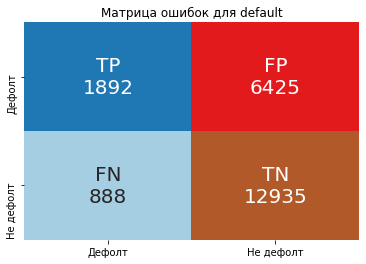

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure()
sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Paired', cbar = False, \
         xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок для default')
plt.show()

# Submission

In [41]:
test_data = X[(X.train == 0)].drop(['train'], axis=1)
test_data

,age,income,bki_request_cnt,decline_app_cnt_log,score_bki,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_nan,home_address_1.0,home_address_2.0,home_address_3.0,home_address_nan,work_address_1.0,work_address_2.0,work_address_3.0,work_address_nan,region_rating_20.0,region_rating_30.0,region_rating_40.0,region_rating_50.0,region_rating_60.0,region_rating_70.0,region_rating_80.0,region_rating_nan,sna_1.0,sna_2.0,sna_3.0,sna_4.0,sna_nan,first_time_1.0,first_time_2.0,first_time_3.0,first_time_4.0,first_time_nan,app_weekday_0.0,app_weekday_1.0,app_weekday_2.0,app_weekday_3.0,app_weekday_4.0,app_weekday_5.0,app_weekday_6.0,app_weekday_nan,app_month_1.0,app_month_2.0,app_month_3.0,app_month_4.0,app_month_nan,sex,car,car_type,foreign_passport,good_work,education_is_nan
73799,-0.888776,0.680428,0.438921,-0.423451,-0.735587,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0
73800,0.120447,-2.624752,-0.002207,4.399062,0.800039,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
73801,0.972731,-0.052822,-0.443335,-0.423451,0.426908,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0
73802,1.362924,-0.868118,-0.443335,-0.423451,-0.940432,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
73803,0.031629,1.937095,-0.884463,-0.423451,-1.167347,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,-0.059496,-1.047780,0.438921,1.535004,0.319505,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
110144,1.823666,2.670346,0.438921,-0.423451,-0.779436,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0
110145,-0.662367,0.942137,-0.443335,2.680628,1.929901,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
110146,-1.130811,-0.052822,-0.002207,1.535004,1.325890,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
y_pred_sub = model.predict(test_data)
submit = pd.DataFrame(df[(df.train == 0)].client_id)
submit['default']=y_pred_sub
submit.to_csv('submission.csv', index=False)